In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os,sys
import glob

### Check the directory

In [2]:
!dir

 Volume in drive C has no label.
 Volume Serial Number is 1C4F-CDB0

 Directory of C:\Users\Kerem\Desktop\nn_final

05.01.2019  21:20    <DIR>          .
05.01.2019  21:20    <DIR>          ..
04.01.2019  22:51    <DIR>          .idea
05.01.2019  21:20    <DIR>          .ipynb_checkpoints
26.12.2018  21:12       303.367.972 d.h5
05.01.2019  02:29    <DIR>          ims
05.01.2019  01:59    <DIR>          lstm from scratch
31.12.2018  13:02             2.551 p.py
05.01.2019  21:20                72 Untitled.ipynb
28.12.2018  17:49         2.339.208 visualizing final project data.ipynb
               4 File(s)    305.709.803 bytes
               6 Dir(s)  133.636.124.672 bytes free


In [47]:
im_path_train = r"C:/Users/Kerem/Desktop/nn_final/ims/train/*.jpg" 
im_path_test = r"C:/Users/Kerem/Desktop/nn_final/ims/test/*.jpg"

im_path_train


'C:/Users/Kerem/Desktop/nn_final/ims/train/*.jpg'

### Check Pictures

#### Below code will show all pictures in the given path. In this case , it will search for those ending with .jpg

In [45]:
my_path = r"C:/Users/Kerem/Desktop/nn_final/ims/*.jpg"

In [46]:
image_list = []
for filename in glob.glob(my_path):
    im=Image.open(filename)
    im.show()
    image_list.append(im)

image size =  (120, 120, 3)


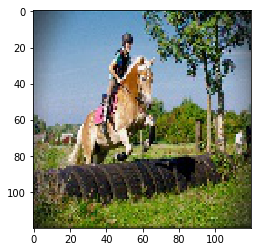

In [64]:
for i in image_list:
    a = np.asarray(i)
    print("image size = ",a.shape)
    plt.imshow(i)

### Get minibatch train data

In [81]:
train_image_list = []
minibatch_size = 200
no_of_images = len(glob.glob(im_path_train)) #75613

current_batch_names = glob.glob(im_path_train)[0:minibatch_size]
current_batch = np.zeros((minibatch_size,120,120,3))

for idx,im in enumerate(current_batch_names):
    current_batch[idx,:,:,:] = np.asarray(Image.open(im))

current_batch.shape

# for filename in glob.glob(im_path_train):
#     im=Image.open(filename)
#     train_image_list.append(im)

(200, 120, 120, 3)

# Builiding Convnet

In [ ]:
def conv_(img, conv_filter):
    # summary: gets called on each filter and each channel (RGB)
    filter_size = conv_filter.shape[1] #i.e. 3
    result = np.zeros((img.shape[0:2]))
    #Looping through the image to apply the convolution operation.
    for r in np.uint16(np.arange(filter_size/2.0, 
                          img.shape[0]-filter_size/2.0+1)):
        for c in np.uint16(np.arange(filter_size/2.0, 
                                           img.shape[1]-filter_size/2.0+1)):
            """
            Getting the current region to get multiplied with the filter.
            How to loop through the image and get the region based on 
            the image and filter sizes is the most tricky part of convolution.
            """
            curr_region = img[r-np.uint16(np.floor(filter_size/2.0)):r+np.uint16(np.ceil(filter_size/2.0)), 
                              c-np.uint16(np.floor(filter_size/2.0)):c+np.uint16(np.ceil(filter_size/2.0))]
            #Element-wise multipliplication between the current region and the filter.
            curr_result = curr_region * conv_filter
            conv_sum = np.sum(curr_result) #Summing the result of multiplication.
            result[r, c] = conv_sum #Saving the summation in the convolution layer feature map.
            
    #Clipping the outliers of the result matrix.
    final_result = result[np.uint16(filter_size/2.0):result.shape[0]-np.uint16(filter_size/2.0), 
                          np.uint16(filter_size/2.0):result.shape[1]-np.uint16(filter_size/2.0)]
    return final_result

In [164]:
def conv(img, conv_filter):
    if len(img.shape) > 2 or len(conv_filter.shape) > 3: # Check if number of image channels matches the filter depth.
        if img.shape[-1] != conv_filter.shape[-1]:
            print("Error: Number of channels in both image and filter must match.")
            sys.exit()
    if conv_filter.shape[1] != conv_filter.shape[2]: # Check if filter dimensions are equal.
        print('Error: Filter must be a square matrix. I.e. number of rows and columns must match.')
        sys.exit()
    if conv_filter.shape[1]%2==0: # Check if filter diemnsions are odd.
        print('Error: Filter must have an odd size. I.e. number of rows and columns must be odd.')
        sys.exit()

    # An empty feature map to hold the output of convolving the filter(s) with the image.
    feature_maps = np.zeros((img.shape[0]-conv_filter.shape[1]+1, 
                                img.shape[1]-conv_filter.shape[1]+1, 
                                conv_filter.shape[0]))

    # Convolving the image by the filter(s).
    for filter_num in range(conv_filter.shape[0]):
        print("Filter ", filter_num + 1)
        curr_filter = conv_filter[filter_num, :] # getting a filter from the bank.
        """ 
        Checking if there are mutliple channels for the single filter.
        If so, then each channel will convolve the image.
        The result of all convolutions are summed to return a single feature map.
        """
# #         print("current filter shape is ",curr_filter.shape)
#         if img.shape[-1] >= 2:
#             for depth in range(curr_filter.shape[-1]):
#                 conv_map = conv_(img[:, :, 0], curr_filter(:,:,:,depth)) # Array holding the sum of all feature maps.
#                 for ch_num in range(1,img.shape[-1]): # Convolving each channel with the image and summing the results.
#                     conv_map = conv_map + conv_(img[:, :, ch_num], 
#                                       curr_filter)
                    
        if len(curr_filter.shape) > 2:  
            conv_map = conv_(img[:, :, 0], curr_filter[:, :, 0]) # Array holding the sum of all feature maps.  
            for ch_num in range(1, curr_filter.shape[-1]): # Convolving each channel with the image and summing the results.  
                 conv_map = conv_map + conv_(img[:, :, ch_num],   
                                   curr_filter[:, :, ch_num])  
                       
                    
                    
                    
        else: # There is just a single channel in the filter.
            conv_map = conv_(img, curr_filter)
        feature_maps[:, :, filter_num] = conv_map # Holding feature map with the current filter.
    return feature_maps # Returning all feature maps.

In [124]:
def pooling(feature_map, size=2, stride=2):
    #Preparing the output of the pooling operation.
    pool_out = np.zeros((np.uint16((feature_map.shape[0]-size+1)/stride+1),
                            np.uint16((feature_map.shape[1]-size+1)/stride+1),
                            feature_map.shape[-1]))
    for map_num in range(feature_map.shape[-1]):
        r2 = 0
        for r in np.arange(0,feature_map.shape[0]-size+1, stride):
            c2 = 0
            for c in np.arange(0, feature_map.shape[1]-size+1, stride):
                pool_out[r2, c2, map_num] = np.max([feature_map[r:r+size,  c:c+size, map_num]])
                c2 = c2 + 1
            r2 = r2 +1
    return pool_out

In [125]:
def relu(feature_map):
    #Preparing the output of the ReLU activation function.
    relu_out = np.zeros(feature_map.shape)
    for map_num in range(feature_map.shape[-1]):
        for r in np.arange(0,feature_map.shape[0]):
            for c in np.arange(0, feature_map.shape[1]):
                relu_out[r, c, map_num] = np.max([feature_map[r, c, map_num], 0])
    return relu_out

### Preparing Filters

In [ ]:
l1_filter = np.zeros((2,3,3)) # 2 filters with 3x3 2D-convolution

#### Set first filters to look for edges

In [ ]:
l1_filter[0, :, :] = np.array([[[-1, 0, 1],   
                                     [-1, 0, 1],   
                                     [-1, 0, 1]]])  
l1_filter[1, :, :] = np.array([[[1,   1,  1],   
                                     [0,   0,  0],   
                                     [-1, -1, -1]]]) 

### Try on sample data (chelsea)

In [93]:
import skimage.data

In [128]:
img_raw = skimage.data.chelsea()
img = skimage.color.rgb2gray(img_raw)

#### Look for image dimensions before and after rgb2gray

##### Before grayscaling

In [129]:
img_raw.shape

(300, 451, 3)

##### After grayscaling

In [130]:
img.shape

(300, 451)

### Apply filters

In [131]:
print("\n**Working with conv layer 1**")
l1_feature_map = conv(img, l1_filter)


**Working with conv layer 1**
Filter  1
Filter  2


In [132]:
l1_feature_map.shape

(298, 449, 2)

### Now apply multiple convolutions

In [145]:
def stack_cnn_layers(img,l1_filter):    
    print("Input shape:",img.shape)
    
    num_of_filters = 2
    kernel_size = [3,3]
    #First conv layer. Fixed: Looks for edges                                                 
    print("\n**Working with conv layer 1**",end="\t")
    print("Number of Filters = {}  Kernel size = {}x{}".format(num_of_filters,kernel_size[0],kernel_size[1]))
  
    l1_feature_map = conv(img, l1_filter)
    print("Shape: ",l1_feature_map.shape )
    
    
    print("\n**ReLU**")
    l1_feature_map_relu = relu(l1_feature_map)
    print("Shape: ",l1_feature_map_relu.shape )

    print("\n**Pooling**")
    l1_feature_map_relu_pool = pooling(l1_feature_map_relu, 2, 2)
    print("Shape: ",l1_feature_map_relu_pool.shape )
    print("**End of conv layer 1**\n")

    # Second conv layer
    num_of_filters = 3
    kernel_size = [5,5]
    
    l2_filter = np.random.rand(3, 5, 5, l1_feature_map_relu_pool.shape[-1])
    print("\n**Working with conv layer 2**",end="\t")
    print("Number of Filters = {}  Kernel size = {}x{}".format(num_of_filters,kernel_size[0],kernel_size[1]))
    l2_feature_map = conv(l1_feature_map_relu_pool, l2_filter)
    print("Shape: ",l2_feature_map.shape )

    print("\n**ReLU**")
    l2_feature_map_relu = relu(l2_feature_map)
    print("Shape: ",l2_feature_map_relu.shape )

    print("\n**Pooling**")
    l2_feature_map_relu_pool = pooling(l2_feature_map_relu, 2, 2)
    print("Shape: ",l2_feature_map_relu_pool.shape )
    
    print("**End of conv layer 2**\n")

    # Third conv layer
    num_of_filters = 1
    kernel_size = [7,7]
    
    l3_filter = np.random.rand(1, 7, 7, l2_feature_map_relu_pool.shape[-1])
    print("\n**Working with conv layer 3**",end="\t")
    print("Number of Filters = {}  Kernel size = {}x{}".format(num_of_filters,kernel_size[0],kernel_size[1]))
    l3_feature_map = conv(l2_feature_map_relu_pool, l3_filter)
    print("Shape: ",l3_feature_map.shape )
    
    print("\n**ReLU**")
    l3_feature_map_relu = relu(l3_feature_map)
    print("Shape: ",l3_feature_map_relu.shape )

    print("\n**Pooling**")
    l3_feature_map_relu_pool = pooling(l3_feature_map_relu, 2, 2)
    print("Shape: ",l3_feature_map_relu_pool.shape )

    print("**End of conv layer 3**\n")
    
    last_feature_map_relu_pool = l3_feature_map_relu_pool
    return last_feature_map_relu_pool

In [146]:
last_feature_map = stack_cnn_layers(img,l1_filter)

Input shape: (300, 451)

**Working with conv layer 1**	Number of Filters = 2  Kernel size = 3x3
Filter  1
Filter  2
Shape:  (298, 449, 2)

**ReLU**
Shape:  (298, 449, 2)

**Pooling**
Shape:  (149, 225, 2)
**End of conv layer 1**


**Working with conv layer 2**	Number of Filters = 3  Kernel size = 5x5
Filter  1
Filter  2
Filter  3
Shape:  (145, 221, 3)

**ReLU**
Shape:  (145, 221, 3)

**Pooling**
Shape:  (73, 111, 3)
**End of conv layer 2**


**Working with conv layer 3**	Number of Filters = 1  Kernel size = 7x7
Filter  1
Shape:  (67, 105, 1)

**ReLU**
Shape:  (67, 105, 1)

**Pooling**
Shape:  (34, 53, 1)
**End of conv layer 3**



### Now try on image caption data

In [167]:
    print("Input shape:",img.shape)
    
    num_of_filters = 2
    kernel_size = [3,3]
    #First conv layer. Fixed: Looks for edges                                                 
    print("\n**Working with conv layer 1**",end="\t")
    print("Number of Filters = {}  Kernel size = {}x{}".format(num_of_filters,kernel_size[0],kernel_size[1]))
  
    l1_feature_map = conv(img, l1_filter)
    print("Shape: ",l1_feature_map.shape )
    
    
    print("\n**ReLU**")
    l1_feature_map_relu = relu(l1_feature_map)
    print("Shape: ",l1_feature_map_relu.shape )

    print("\n**Pooling**")
    l1_feature_map_relu_pool = pooling(l1_feature_map_relu, 2, 2)
    print("Shape: ",l1_feature_map_relu_pool.shape )
    print("**End of conv layer 1**\n")

Input shape: (120, 120, 3)

**Working with conv layer 1**	Number of Filters = 2  Kernel size = 3x3
Filter  1


ValueError: could not broadcast input array from shape (118,118,3) into shape (118,118)

In [165]:
minibatch_l1_feature_map = []
for img in current_batch[0:5]:
    last_feature_map = stack_cnn_layers(img,l1_filter)

Input shape: (120, 120, 3)

**Working with conv layer 1**	Number of Filters = 2  Kernel size = 3x3
Filter  1


ValueError: could not broadcast input array from shape (118,118,3) into shape (118,118)

In [166]:
img.shape

(120, 120, 3)

In [92]:
current_batch[0].shape

(120, 120, 3)

In [106]:
np.arange(1,10,2)

array([1, 3, 5, 7, 9])

In [108]:
np.uint16(3/2.0)

1

### Extra: Adding stride and padding

In [121]:
def custom_conv_(img, conv_filter,stride=2):
    #have not consider padding yet
    
    
    # summary: gets called on each filter and each channel (RGB)
    filter_size = conv_filter.shape[1] #i.e. 3
    result = np.zeros((img.shape))
    #Looping through the image to apply the convolution operation.
    for r in np.uint16(np.arange(filter_size/2.0, 
                          img.shape[0]-filter_size/2.0+1,stride)):
        for c in np.uint16(np.arange(filter_size/2.0, 
                                           img.shape[1]-filter_size/2.0+1,stride)):
            """
            Getting the current region to get multiplied with the filter.
            How to loop through the image and get the region based on 
            the image and filter sizes is the most tricky part of convolution.
            """
            curr_region = img[r-np.uint16(np.floor(filter_size/2.0)):r+np.uint16(np.ceil(filter_size/2.0)), 
                              c-np.uint16(np.floor(filter_size/2.0)):c+np.uint16(np.ceil(filter_size/2.0))]
            #Element-wise multipliplication between the current region and the filter.
            curr_result = curr_region * conv_filter
            conv_sum = np.sum(curr_result) #Summing the result of multiplication.
            result[r, c] = conv_sum #Saving the summation in the convolution layer feature map.
            
    #Clipping the outliers of the result matrix.
    final_result = result[np.uint16(filter_size/2.0):result.shape[0]-np.uint16(filter_size/2.0), 
                          np.uint16(filter_size/2.0):result.shape[1]-np.uint16(filter_size/2.0)]
    return final_result

In [123]:
def custom_conv(img, conv_filter,padding=0,stride=1):
    # Summary: Checks dim errors, verboses, and adjusts for the channels
    
    if len(img.shape) > 2 or len(conv_filter.shape) > 3: # Check if number of image channels matches the filter depth.
        if img.shape[-1] != conv_filter.shape[-1]:
            print("Error: Number of channels in both image and filter must match.")
            sys.exit()
    if conv_filter.shape[1] != conv_filter.shape[2]: # Check if filter dimensions are equal.
        print('Error: Filter must be a square matrix. I.e. number of rows and columns must match.')
        sys.exit()
    if conv_filter.shape[1]%2==0: # Check if filter diemnsions are odd.
        print('Error: Filter must have an odd size. I.e. number of rows and columns must be odd.')
        sys.exit()

    # An empty feature map to hold the output of convolving the filter(s) with the image.
    # added padding and stride
    feature_maps = np.zeros((((img.shape[0]-conv_filter.shape[1]+2*padding)/stride)+1, 
                                ((img.shape[1]-conv_filter.shape[1]+2*padding)/stride)+1, 
                                conv_filter.shape[0]))

    # Convolving the image by the filter(s).
    for filter_num in range(conv_filter.shape[0]):
        print("Filter ", filter_num + 1)
        curr_filter = conv_filter[filter_num, :] # getting a filter from the bank.
        """ 
        Checking if there are mutliple channels for the single filter.
        If so, then each channel will convolve the image.
        The result of all convolutions are summed to return a single feature map.
        """
        if len(curr_filter.shape) > 2: #if RGB instead of Grayscale for example
            conv_map = conv_(img[:, :, 0], curr_filter[:, :, 0]) # Array holding the sum of all feature maps.
            for ch_num in range(1, curr_filter.shape[-1]): # Convolving each channel with the image and summing the results.
                conv_map = conv_map + conv_(img[:, :, ch_num], 
                                  curr_filter[:, :, ch_num])
        else: # There is just a single channel in the filter.
            conv_map = conv_(img, curr_filter)
        feature_maps[:, :, filter_num] = conv_map # Holding feature map with the current filter.
    return feature_maps # Returning all feature maps.